In [1]:
import torch
print(torch.backends.mps.is_available())  # Should return True
print(torch.backends.mps.is_built())  # Should return True

True
True


In [ ]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import os
from torch.utils.data import DataLoader, TensorDataset

def load_images(folder_path, label):
    images, labels = [], []
    for i in range(500):  # 500 images per folder
        img_path = os.path.join(folder_path, f"{i:03d}.jpg")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        img = img.flatten() / 255.0  # Normalize and flatten to 1024
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load datasets
animal_images, animal_labels = load_images(r"group_1/dog", label=1)
object_images, object_labels = load_images(r"group_1/automobile", label=0)

# Combine datasets
X = np.vstack((animal_images, object_images))
Y = np.hstack((animal_labels, object_labels))

# Shuffle the dataset randomly
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X, Y = X[indices], Y[indices]

# Compute global mean and variance
global_mean = np.mean(X, axis=0)
global_variance = np.var(X, axis=0)

# Normalize dataset
X_normalized = (X - global_mean) / (np.sqrt(global_variance) + 1e-8)

# Ensure correct shape for input tensors
X_train = torch.tensor(X_normalized[:900], dtype=torch.float32)
Y_train = torch.tensor(Y[:900], dtype=torch.float32).unsqueeze(1)  # Add extra dimension

X_val = torch.tensor(X_normalized[900:], dtype=torch.float32)
Y_val = torch.tensor(Y[900:], dtype=torch.float32).unsqueeze(1)  # Add extra dimension

# Ensure shapes match
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

# Create DataLoaders for batch processing
batch_size = 16
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=batch_size, shuffle=False)

# -------------------------------
# Step 2: Define MLP Model
# -------------------------------
class MLP(nn.Module):
    def __init__(self, input_size=1024, hidden_size1=256, hidden_size2=128, hidden_size3=64):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden_size1)
        self.hidden2 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden3 = nn.Linear(hidden_size2, hidden_size3)
        self.output = nn.Linear(hidden_size3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.sigmoid(self.output(x))
        return x

X_train shape: torch.Size([900, 1024]), Y_train shape: torch.Size([900, 1])
X_val shape: torch.Size([100, 1024]), Y_val shape: torch.Size([100, 1])


In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = MLP().to(device)

In [6]:
# Move training and validation data to device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_val = X_val.to(device)

In [7]:
# Define Loss & Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# Step 3: Train MLP with Batch Mode + Early Stopping
# -------------------------------
num_epochs = 50
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float("inf")
early_stop_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [10]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_train, total_train = 0, 0

    for X_batch, Y_batch in train_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # Move to MPS
        optimizer.zero_grad()
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Compute training accuracy
        predicted = (Y_pred >= 0.5).float()
        correct_train += (predicted == Y_batch).sum().item()
        total_train += Y_batch.size(0)

    train_losses.append(epoch_loss / len(train_loader))
    train_accs.append(100 * correct_train / total_train)

    # Validation Phase
    model.eval()
    val_loss = 0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            Y_pred = model(X_batch)
            val_loss += criterion(Y_pred, Y_batch).item()

            # Compute validation accuracy
            predicted = (Y_pred >= 0.5).float()
            correct_val += (predicted == Y_batch).sum().item()
            total_val += Y_batch.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * correct_val / total_val)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Acc = {train_accs[-1]:.2f}%, Val Acc = {val_accs[-1]:.2f}%")

Epoch 1/50: Train Acc = 74.11%, Val Acc = 85.00%
Epoch 2/50: Train Acc = 85.11%, Val Acc = 83.00%
Epoch 3/50: Train Acc = 87.78%, Val Acc = 85.00%
Epoch 4/50: Train Acc = 90.44%, Val Acc = 80.00%
Epoch 5/50: Train Acc = 91.11%, Val Acc = 83.00%
Epoch 6/50: Train Acc = 94.44%, Val Acc = 86.00%
Epoch 7/50: Train Acc = 96.78%, Val Acc = 86.00%
Epoch 8/50: Train Acc = 95.00%, Val Acc = 87.00%
Epoch 9/50: Train Acc = 97.00%, Val Acc = 86.00%
Epoch 10/50: Train Acc = 97.44%, Val Acc = 87.00%
Epoch 11/50: Train Acc = 98.89%, Val Acc = 87.00%
Epoch 12/50: Train Acc = 98.22%, Val Acc = 87.00%
Epoch 13/50: Train Acc = 98.56%, Val Acc = 89.00%
Epoch 14/50: Train Acc = 99.89%, Val Acc = 89.00%
Epoch 15/50: Train Acc = 100.00%, Val Acc = 91.00%
Epoch 16/50: Train Acc = 100.00%, Val Acc = 91.00%
Epoch 17/50: Train Acc = 100.00%, Val Acc = 91.00%
Epoch 18/50: Train Acc = 100.00%, Val Acc = 91.00%
Epoch 19/50: Train Acc = 100.00%, Val Acc = 91.00%
Epoch 20/50: Train Acc = 100.00%, Val Acc = 91.00%
Epo

Final Training Accuracy: 100.00%
Final Validation Accuracy: 91.00%


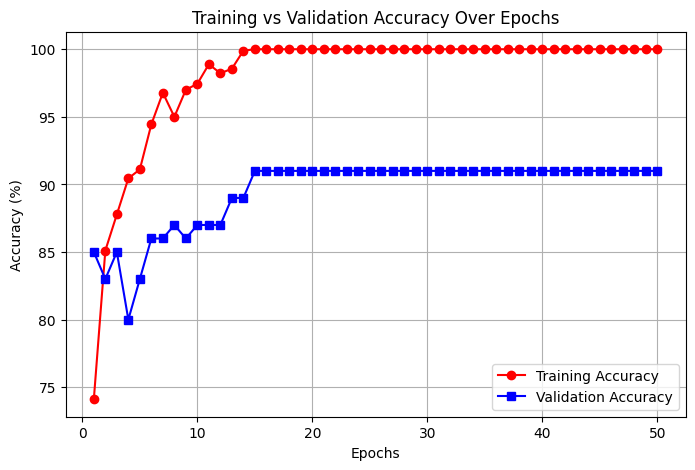

In [12]:
# -------------------------------
def evaluate_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # Move to MPS
            Y_pred = model(X_batch).round()
            correct += (Y_pred == Y_batch).sum().item()
            total += Y_batch.size(0)
    return 100 * correct / total

train_accuracy = evaluate_accuracy(train_loader)
val_accuracy = evaluate_accuracy(val_loader)

print(f"Final Training Accuracy: {train_accuracy:.2f}%")
print(f"Final Validation Accuracy: {val_accuracy:.2f}%")

import matplotlib.pyplot as plt
# -------------------------------
# Step 4: Plot Accuracy Over Epochs
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accs, label="Training Accuracy", marker='o', color='red')
plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker='s', color='blue')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [20]:
def test_model(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Image not found at {image_path}")
        return
    # Resize image to 32x32
    img = cv2.resize(img, (32, 32))
    # Preprocess: flatten and normalize
    img = img.flatten() / 255.0
    # Create input batch of shape (1, 1024)
    X_test = np.array([img])
    # Get prediction from the trained perceptron model
    prediction = model.predict(X_test)
    # Output the result
    class_label = "Dog" if prediction[0] == 1 else "Automobile"
    print(f"Prediction for {image_path}: {class_label}")
# Test on a sample image (update the path as needed)
test_model(r"dog_test.jpeg")
test_model(r"car_test.jpg")

AttributeError: 'MLP' object has no attribute 'predict'